# Plot model output

started 2023-05-12
by Eva Lieungh, Lasse T. Keetz, chatGPT

Notebook copied and modified from the [LSP](https://github.com/NorESMhub/noresm-land-sites-platform), which again is inspired from other sources like CTSM and FATES tutorials (e.g. [NCAR/ctsm_python_gallery](https://github.com/NCAR/ctsm_python_gallery)).

Prerequisite: Concatenate history files (one file per month of the simulation) into a single file. Notebook in ../data_handling

In this notebook:
1. read in concatenated output files from five simulations from the manuscript
2. plot aboveground biomass per PFT in all simulations
3. plot productivity / carbon fluxes in all simulations

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import pandas as pd
import numpy as np

Define names and paths to the NetCDF output. First print the current working directory, should be myforderstructure/FATES_INCLINE/src/analysis_and_plotting

In [2]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


In [2]:
# Set simulation (case) names
DA = "alp4-1500-gswp3-DA"
DB = "alp4-1500-gswp3-DB"
IA = "alp4-1500-cosmo-IA"
IB = "alp4-1500-cosmo-IB"
IW = "alp4-1500-warmed-IW"
IBSP = "alp4-1500-cosmo-IBSP"
IWSP = "alp4-1500-warmed-IWSP"

file_paths = {
    'DA': "alp4-1500-gswp3-DA",
    'DB': "alp4-1500-gswp3-DB",
    'IA': "alp4-1500-cosmo-IA",
    'IB': "alp4-1500-cosmo-IB",
    'IW': "alp4-1500-warmed-IW",
    'IBSP' : "alp4-1500-cosmo-IBSP",
    'IWSP': "alp4-1500-warmed-IWSP"
}

# Enter the site code from the LSP
site_code = "ALP4"

Enter the file path and names of the output files

In [3]:
# Path to concatenated land archive output
output_data_path = f"../../results"

# Enter the names of single output files from each simulation, created with the 'combine_model_history_files' notebook.
file_path_DA = f"{output_data_path}/{file_paths['DA']}/alp4-1500-gswp3-DA.0-1500.nc"
file_path_DB = f"{output_data_path}/{file_paths['DB']}/alp4-1500-gswp3-DB.0-1500.nc"
file_path_IA = f"{output_data_path}/{file_paths['IA']}/alp4-1500-cosmo-IA.0-1500.nc"
file_path_IB = f"{output_data_path}/{file_paths['IB']}/alp4-1500-cosmo-IB.0-1500.nc"
file_path_IW = f"{output_data_path}/{file_paths['IW']}/alp4-1500-warmed-IW.0-1500.nc"
file_path_IBSP = f"{output_data_path}/{file_paths['IBSP']}/alp4-1500-cosmo-IBSP.0-1500.nc"
file_path_IWSP = f"{output_data_path}/{file_paths['IWSP']}/alp4-1500-warmed-IWSP.0-1500.nc"

In [5]:
# check that it looks correct
file_path_IW

'../../results/alp4-1500-warmed-IW/alp4-1500-warmed-IW.0-1500.nc'

Read in the data files

In [ ]:
# Manual way to read one by one
#DA_data = xr.open_mfdataset(file_path_DA,
#                            combine='by_coords',
#                            decode_times=True
#                            )

In [15]:
# Alternative with loop:
file_paths = {
    'DA': file_path_DA,
    'DB': file_path_DB,
    'IA': file_path_IA,
    'IB': file_path_IB,
    'IW': file_path_IW,
    'IBSP': file_path_IBSP,
    'IWSP': file_path_IWSP
}

data = {}

for dataset, path in file_paths.items():
    data[dataset] = xr.open_mfdataset(path, 
                                      combine='by_coords', 
                                      decode_times=True)

Define folder for the case's output plots

In [5]:
# set folder
plot_save_path = Path("../../results/figures/")

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, 
                         exist_ok=True)

### Data set exploration
The code cell below prints relevant information about a NetCDF file with the `xarray` package. Note that you can click in the printed information below to display more informaton.

In [8]:
# Print full dataset information
data["IW"]
#IA_data # manual alternative

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 39,
                                       fates_levcacls: 2, fates_levcapf: 6,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 3, fates_levfuel: 6,
                                       ...
                                       fates_levagepft: 21,
                                       fates_levagefuel: 42, fates_levcdsc: 26,
                                       fates_levcdpf: 78, fates_levcdam: 2,
                                       time: 18000, hist_interval: 2,
                                       lndgrid: 1, fates_levelem: 1,
                                       fates_levelcwd: 4, glc_nec: 10, ltype: 9)
Coordinates: (12/15)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * fates_levcdam                     (fates_levcdam) float32 0.0 80.0
  * time                              (time) object 0001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval, lndgrid, fates_levelem,
                                fates_levelcwd, glc_nec, ltype
Data variables: (12/505)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(39,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(39,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(18000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(18000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(18000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(18000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(18000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(18000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Thu Jun 29 15:31:

---
# Create simple time series line plots
##### Plot variables with only time and lndgrid dimensions.
There are multiple ways to create output plots from xarray `DataArray` objects, i.e., for all the variables contained in the full xarray `DataSet` that we created when reading in the NetCDF files. For more details, check https://docs.xarray.dev/en/latest/user-guide/plotting.html.

Let's start by selecting one of the `Data variables` from the output above that only has `time` and `lndgrid` dimensions (listed in the parentheses in the second column when you display the data). 

Next, explore your choice by assigning the specific variable object to a new Python variable and by printing its content.

In [16]:
# define variable name for aboveground biomass
AGB_var = "FATES_VEGC_ABOVEGROUND"

# extract AGB from one of the data sets
var = data["IW"][AGB_var]

var

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND' (time: 18000, lndgrid: 1)>
dask.array<open_dataset-8d1fafa09b91622ba6325ffdd1c2f844FATES_VEGC_ABOVEGROUND, shape=(18000, 1), dtype=float32, chunksize=(18000, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 1501-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      aboveground biomass in kg carbon per m2 land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

When plotting, use a workaround to avoid errors with the time variable

In [11]:
data["IW"].indexes['time']

CFTimeIndex([0001-02-01 00:00:00, 0001-03-01 00:00:00, 0001-04-01 00:00:00,
             0001-05-01 00:00:00, 0001-06-01 00:00:00, 0001-07-01 00:00:00,
             0001-08-01 00:00:00, 0001-09-01 00:00:00, 0001-10-01 00:00:00,
             0001-11-01 00:00:00,
             ...
             1500-04-01 00:00:00, 1500-05-01 00:00:00, 1500-06-01 00:00:00,
             1500-07-01 00:00:00, 1500-08-01 00:00:00, 1500-09-01 00:00:00,
             1500-10-01 00:00:00, 1500-11-01 00:00:00, 1500-12-01 00:00:00,
             1501-01-01 00:00:00],
            dtype='object', length=18000, calendar='noleap', freq='MS')

Make a simple plot for one of the simulations:

In [17]:
# Create year labels for x axis (otherwise shows month 0-18000)
tick_locations = [0, # first year
                  6000, # year 500 = 500*12months
                  12000, # year 1000
                  18000 # year 1500
                  ]
labels = ['1','500','1000','1500']


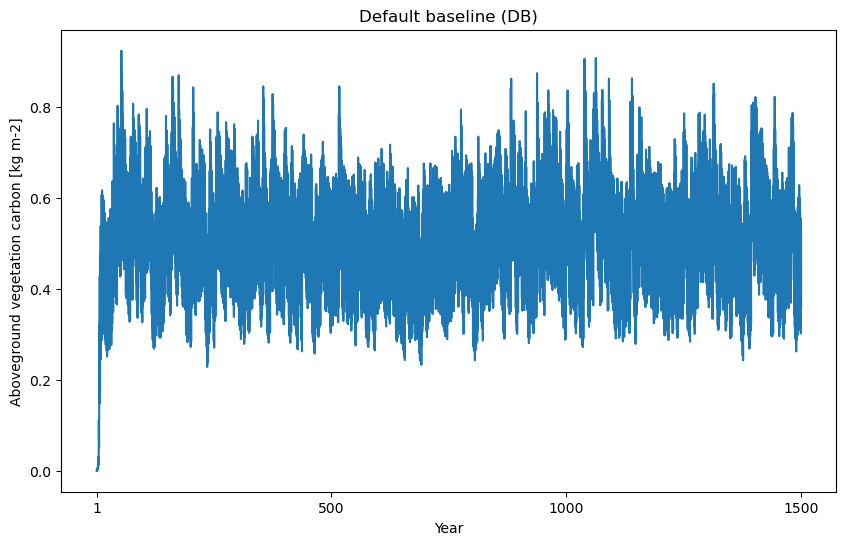

In [18]:

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(data['DB']["time"])), # x axis
        data['DB']["FATES_VEGC_ABOVEGROUND"]) # y axis
ax.set_title(f"Default baseline (DB)") # simulation name
ax.set_xlabel("Year")
ax.set_ylabel(f"Aboveground vegetation carbon [{data['DB'][AGB_var].units}]")

# Set x-axis tick labels every 500 years
ax.set_xticks(tick_locations)
ax.set_xticklabels(labels)

plt.show()


And then the same plot but for all the simulations

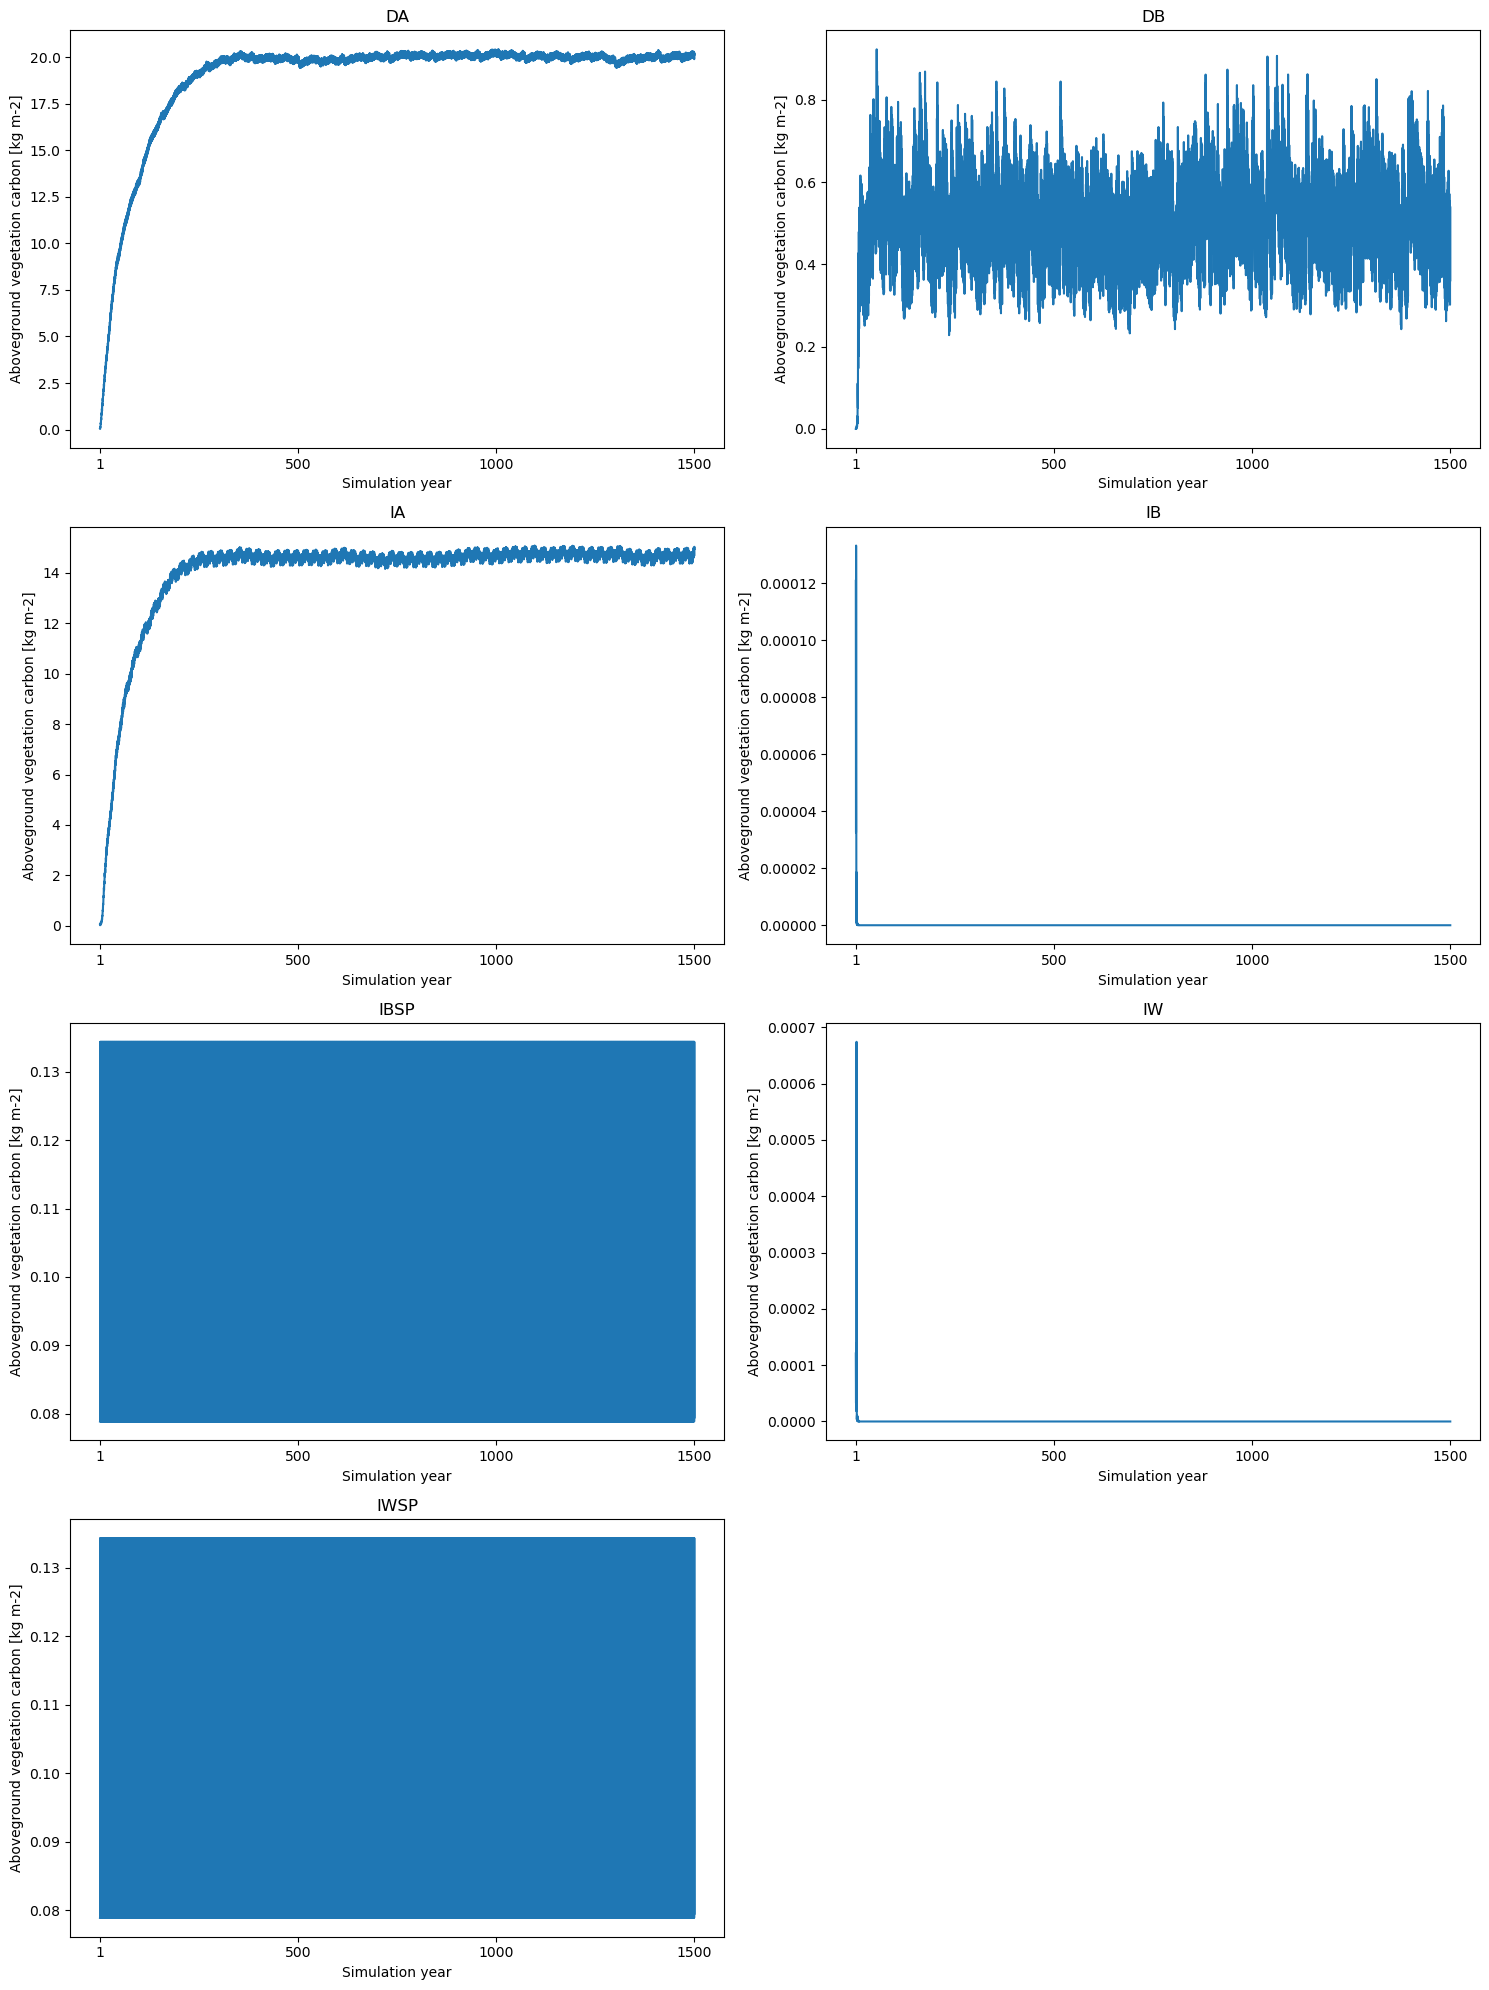

In [19]:
# list simulations
simulations = ['DA', 
               'DB', 
               'IA', 
               'IB', 
               'IBSP',
               'IW', 
               'IWSP'
               ]

# Instantiate figure with individual figures next to each other
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(15, 20)
)

# Delete empty axis object if number of simulations in list is odd
if len(axes.flatten()) != len(simulations):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# Plot all variables
for i, simulation in enumerate(simulations):
    ax = axes.flatten()[i]  # Get the appropriate axis object
    ax.plot(range(len(data[simulation]["time"])), 
            data[simulation]["FATES_VEGC_ABOVEGROUND"]) 
    ax.set_title(simulation)
    ax.set_xlabel("Simulation year")
    ax.set_ylabel(f"Aboveground vegetation carbon [{data[simulation]['FATES_VEGC_ABOVEGROUND'].units}]")
    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot

---

# Plot biomass (carbon) per PFT
The output variable `FATES_VEGC_PF` stores the amount of total biomass in kg of carbon per land area for each included PFT.

In [20]:
# Variable name for biomass per PFT in dataset
var_name = "FATES_VEGC_PF"

## Simulations with all PFTs

Plot first for the default and improved simulations with *all* PFTs included (DA, IA).

In [21]:
"""
Load and create dictionaries defining PFT and plot properties.
NB: this is version and model setting dependent!
The 'fates_pft_dict' keys are the PFT indices used in the FATES output.
"""
# open all-PFT dictionary
with open(Path("./dicts/default_fates_pfts.json"), 'r', encoding='utf-8') as fates_pft_json:
    fates_pft_dict = json.load(fates_pft_json)

# group by growth form
pft_group_plot_dict = {
    "tree": {
        "linestyle": "-"
    },
    "shrub": {
        "linestyle": "--"
    },
    "grass": {
        "linestyle": ":"
    }
}


#### Default inputs, all PFTs simulation

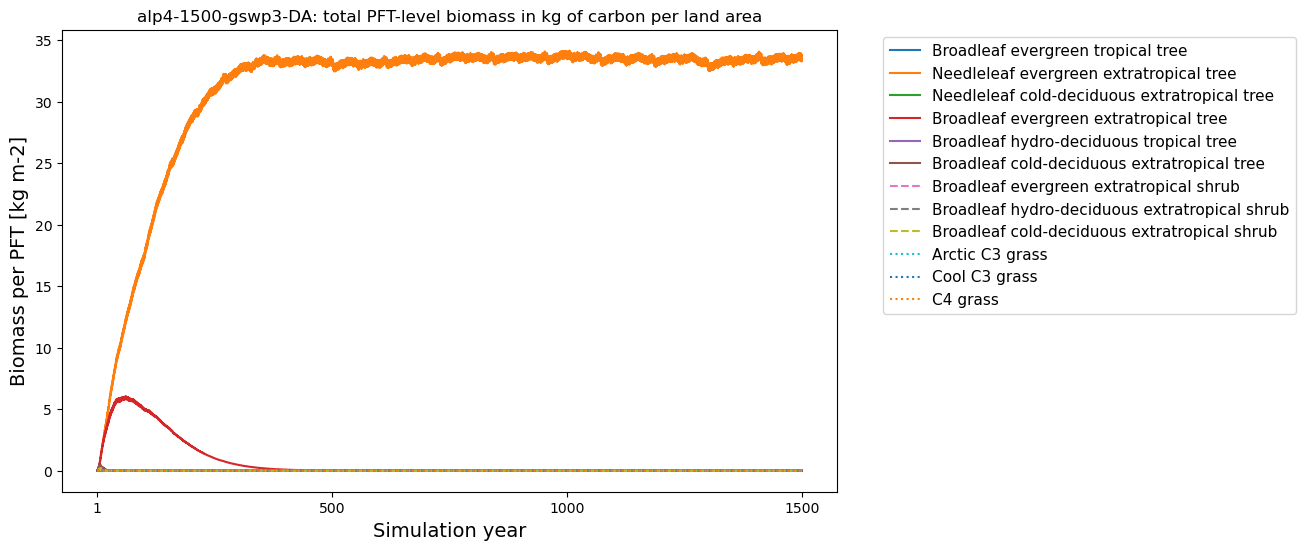

In [22]:
# subset variable from data
pft_biomass = data["DA"]["FATES_VEGC_PF"]

# Instantiate plot
fig, ax = plt.subplots(figsize=(10,6))

# Create a multi-line plot by looping through PFT properties
plot_handle_list = []

# Determine whether default or customized PFTs were used based on boolean variable
pft_dict = fates_pft_dict

for cur_pft_idx in pft_biomass.fates_levpft:
    
    cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
    
    # Plot biomass for current PFT index
    cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                pft_biomass.sel(fates_levpft=cur_pft_idx),
                                label=cur_pft_dict["long_name"],
                                linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                linewidth=1.5
                               )
    
    plot_handle_list.append(cur_plot_handles)

# Set overall plot layout
ax.set_title(f"{DA}: {pft_biomass.long_name}")
ax.set_xlabel("Simulation year", fontsize=14)
ax.set_ylabel(f"Biomass per PFT [{pft_biomass.units}]", fontsize=14)

# Set x-axis tick labels every 500 years
ax.set_xticks(tick_locations)
ax.set_xticklabels(labels)

ax.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
);

#### Plot both DA and IA biomass together

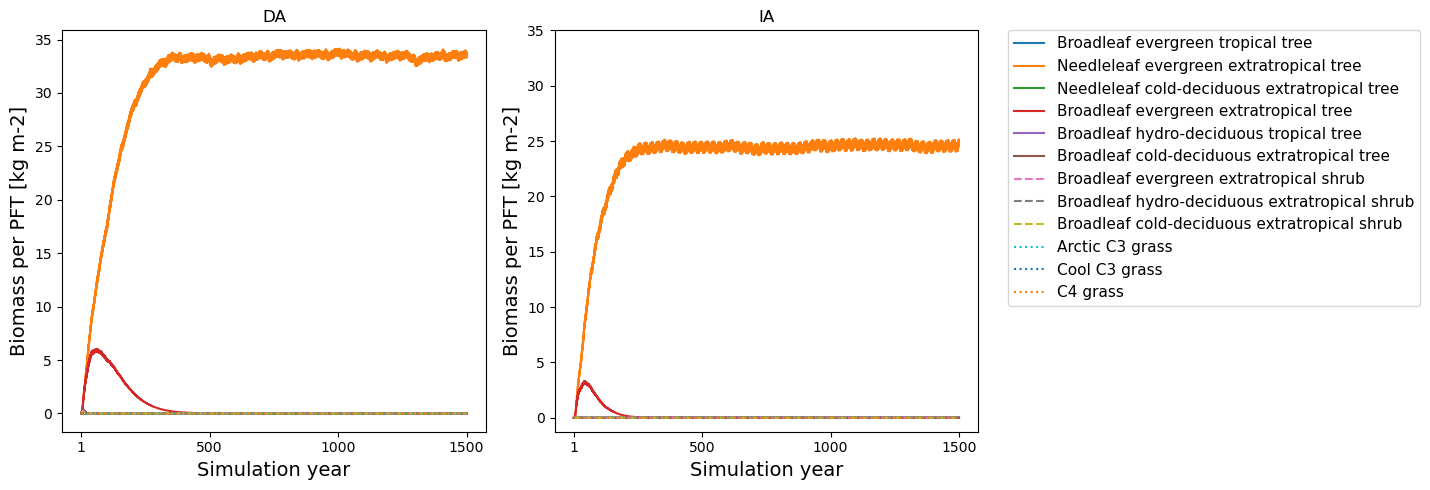

In [29]:
# list simulations to include
simulations = ['DA', 'IA']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_VEGC_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use default PFT dictionary
    pft_dict = fates_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Biomass per PFT [{pft_biomass.units}]", fontsize=14)
    
    # set the same y axis length
    ax.set_yticks(np.linspace(0, 35, num=8))    

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.005, 0.945),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


## Grass PFTs only simulations

Plot vegetation biomass (carbon) for simulations DB, IB, IW simulations.

Get a custom PFT dictionary for grass PFTs. 

In [25]:
custom_pft_indices = [  # Add the comma-seperated list of PFT indices below.
        10, 11, 12
    ]

# Create new dict for included PFTs from default
custom_pft_dict = {str(idx+1): fates_pft_dict[str(pft_idx)] for idx, pft_idx in enumerate(custom_pft_indices)}
print(custom_pft_dict)

{'1': {'long_name': 'Arctic C3 grass', 'group': 'grass'}, '2': {'long_name': 'Cool C3 grass', 'group': 'grass'}, '3': {'long_name': 'C4 grass', 'group': 'grass'}}


Look at the biomass per PFT variable before making the next plot.

In [26]:
# Display variable details for the DB simulation
pft_biomass = data["IB"]["FATES_VEGC_PF"]
pft_biomass

<xarray.DataArray 'FATES_VEGC_PF' (time: 18000, fates_levpft: 3, lndgrid: 1)>
dask.array<open_dataset-b101760ca1740200ea6d29ec22af48f6FATES_VEGC_PF, shape=(18000, 3, 1), dtype=float32, chunksize=(18000, 3, 1), chunktype=numpy.ndarray>
Coordinates:
  * fates_levpft  (fates_levpft) int32 1 2 3
  * time          (time) object 0001-02-01 00:00:00 ... 1501-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      total PFT-level biomass in kg of carbon per land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

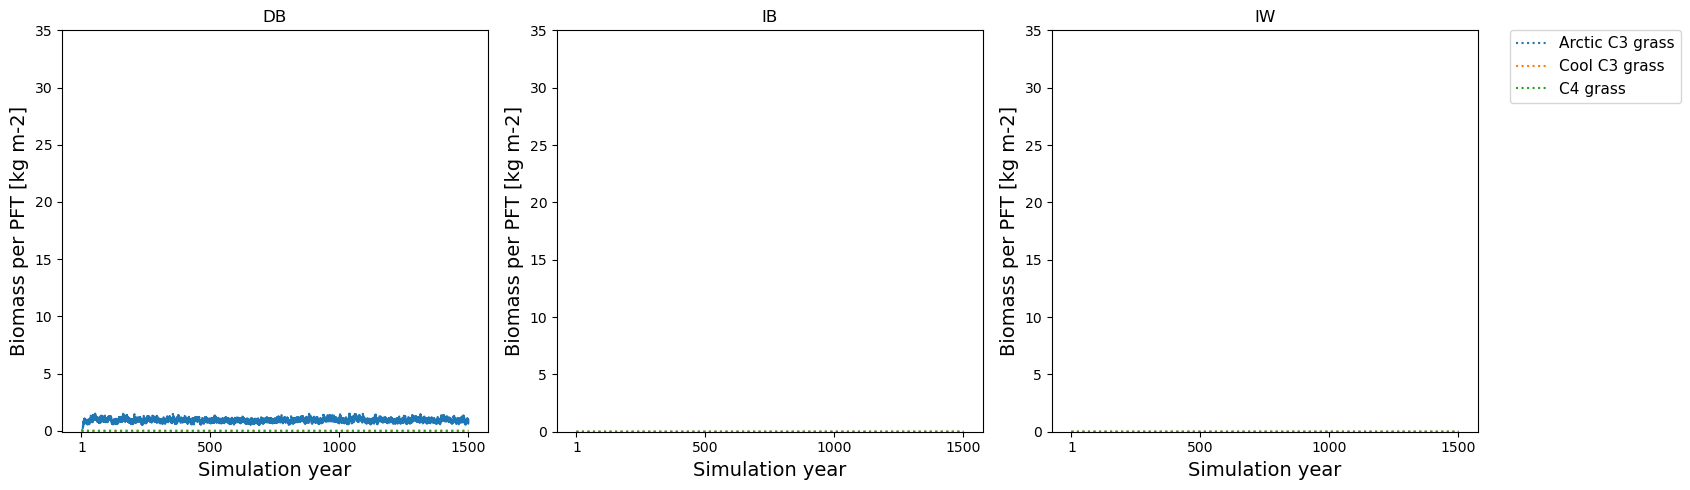

In [27]:
import matplotlib.pyplot as plt

# list simulations to include
simulations = ['DB', 
               'IB',
               'IW']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 5)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_VEGC_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use customized PFT dictionary
    pft_dict = custom_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Biomass per PFT [{pft_biomass.units}]", fontsize=14)
    
    # set the same y axis length
    ax.set_yticks(np.linspace(0, 35, num=8))    

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.005, 0.945),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


## SP simulations

**NB not functioning properly**
Same for the SP simulations. Note that biomass is prescribed here, so we're plotting something predefined and *not* dynamically simulated. 

In [50]:
sp_pft_indices = [  # Add the comma-seperated list of PFT indices below.
        9, 10, 11
    ]

# Create new dict for included PFTs from default
sp_pft_dict = {str(idx+1): fates_pft_dict[str(pft_idx)] for idx, pft_idx in enumerate(sp_pft_indices)}
print(sp_pft_dict)

{'1': {'long_name': 'Broadleaf cold-deciduous extratropical shrub', 'group': 'shrub'}, '2': {'long_name': 'Arctic C3 grass', 'group': 'grass'}, '3': {'long_name': 'Cool C3 grass', 'group': 'grass'}}


KeyError: '4'

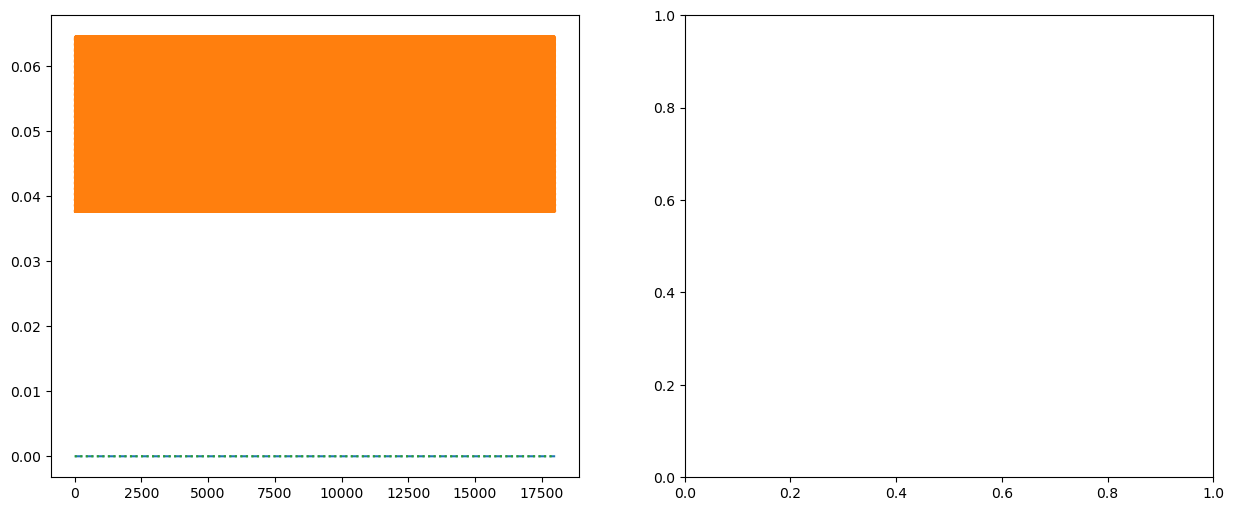

In [52]:
import matplotlib.pyplot as plt

# list simulations to include
simulations = ['IBSP',
               'IWSP']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_VEGC_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use customized PFT dictionary
    pft_dict = sp_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Biomass per PFT [{pft_biomass.units}]", fontsize=14)

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.01, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


Note that this plot shows the **total PFT-level biomass**, ergo the sum of the above- and belowground biomasses of all respective PFT cohorts across all simulated patches, scaled to kg/m².

---
# Plot productivity/fluxes per PFT

Variables:

- FATES_GPP: gross primary production in kg carbon per m2 per second
- FATES_AUTORESP: autotrophic respiration in kg carbon per m2 per second
- FATES_HET_RESP: heterotrophic respiration in kg carbon per m2 per second
- FATES_NEP: net ecosystem production in kg carbon per m2 per second

## Boxplots of GPP, NPP, respiration

Start by subsetting data for the relevant variables, converting from monthly to yearly values, and subset the last 10 years of simulation. Takes 3-5 mins.

In [6]:
# define which simulations to include
simulations = ['DA', 
               'DB', 
               'IA', 
               'IB', 
               'IBSP', 
               'IW', 
               'IWSP'
               ]

# define output variables to include
c_flux_var_names = [
    "FATES_GPP",
    "FATES_AUTORESP",
    "FATES_HET_RESP",
    "FATES_NEP"
]

# Dictionary to store dataframes for each simulation
dfs = {}  

# do data handling in loop for all the simulations
for sim in simulations:
    c_flux_vars = [data[sim][name] for name in c_flux_var_names]
    # Convert to yearly output. 
    # Monthly output, averaged for unit kg C m-2 s-1. To convert to total yearly (kg C m-2 yr-1):
    # 1 month on average = 2,628,288 seconds, sum up monthly values
    c_flux_vars_annual = [(var * 2628288).resample(time='1Y').sum(keep_attrs=True) for var in c_flux_vars]
    #Subset last 10 years
    n_years = 10
    c_fluxes_last_10y = [var.values.flatten()[-n_years-1:-1] for var in c_flux_vars_annual]
    # Create DataFrame
    c_fluxes_df = pd.DataFrame(columns=[var.name for var in c_flux_vars])
    
    for idx, var in enumerate(c_fluxes_df.columns):
        c_fluxes_df[var] = c_fluxes_last_10y[idx]
    # store in dictionary
    dfs[sim] = c_fluxes_df

# Example: dfs['DA'] for simulation 'DA'
dfs['DA']

FATES_GPP  FATES_AUTORESP  FATES_HET_RESP  FATES_NEP
0   2.118291        0.805184        1.292713   0.020394
1   2.226978        0.846991        1.254580   0.125408
2   2.182228        0.839155        1.364646  -0.021573
3   2.134709        0.835633        1.149581   0.149494
4   2.235563        0.850909        1.235730   0.148924
5   2.166198        0.850015        1.440967  -0.124783
6   2.127336        0.792419        1.097027   0.237890
7   2.111791        0.813457        1.279890   0.018444
8   2.017460        0.807322        1.138131   0.072008
9   2.196194        0.832878        1.472515  -0.109199

In [7]:
# Set general plotting options
TICK_LABEL_FONT_SIZE = 11
AX_LABEL_FONT_SIZE = 12

In [41]:
# Iterate over simulations and create plots
for sim, df in dfs.items():
    # Instantiate plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    
    box_plot = ax.boxplot(
        df,
        patch_artist=True,
        medianprops={
            'linewidth': 2,
            'color': 'black'
        }
    )

    box_color = '#28282B80'
    for patch in box_plot['boxes']:
        patch.set_facecolor(box_color)

    x_labels = [
        "GPP",
        r"R$_{A}$",
        r"R$_{H}$",
        "NEP"
    ]

    ax.set_title(sim)
    ax.set_xticklabels(x_labels, fontsize=AX_LABEL_FONT_SIZE - 1)
    ax.set_ylabel("Total annual flux\n(kg C / m² / year)", fontsize=AX_LABEL_FONT_SIZE)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
    ax.tick_params(axis='x', which='major', labelsize=AX_LABEL_FONT_SIZE)

    # Manually set y-ticks
    max_y = max(ax.get_yticks())
    min_y = min(ax.get_yticks())
    ax.set_yticks(np.linspace(min_y, max_y, num=5))

    # Save figure
    fig.tight_layout()
    fig.savefig(fname=f"{plot_save_path}/modelled_c_fluxes_{sim}.png", format='png')
    plt.close(fig)  # Close the figure to free up memory

Same but with all the plots in a grid:

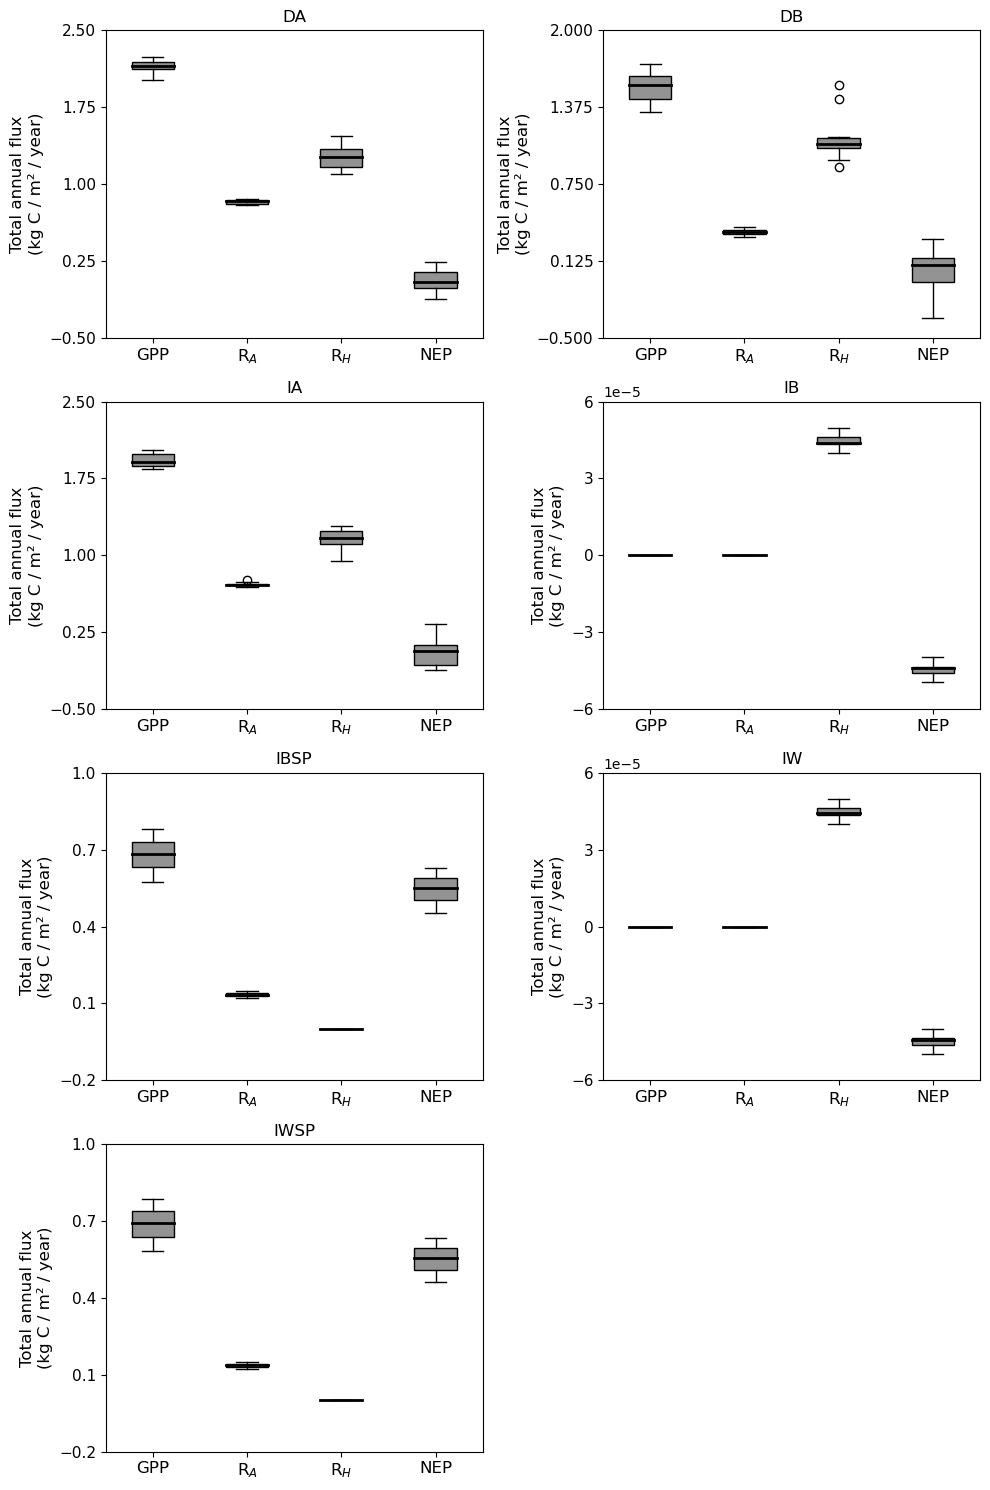

In [46]:
# Instantiate figure with individual figures next to each other
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 15)
)

# Delete empty axis object if number of simulations in list is odd
if len(axes.flatten()) != len(simulations):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

for index, (sim, df) in enumerate(dfs.items()):
    # Instantiate plot
    ax = axes[index // 2, index % 2]  # Get the appropriate axis object for the current subplot
        
    box_plot = ax.boxplot(
        df,
        patch_artist=True,
        medianprops={
            'linewidth': 2,
            'color': 'black'
        }
    )

    box_color = '#28282B80'
    for patch in box_plot['boxes']:
        patch.set_facecolor(box_color)

    x_labels = [
        "GPP",
        r"R$_{A}$",
        r"R$_{H}$",
        "NEP"
    ]

    ax.set_title(sim)
    ax.set_xticklabels(x_labels, fontsize=AX_LABEL_FONT_SIZE - 1)
    ax.set_ylabel("Total annual flux\n(kg C / m² / year)", fontsize=AX_LABEL_FONT_SIZE)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
    ax.tick_params(axis='x', which='major', labelsize=AX_LABEL_FONT_SIZE)

    # Manually set y-ticks
    max_y = max(ax.get_yticks())
    min_y = min(ax.get_yticks())
    ax.set_yticks(np.linspace(min_y, max_y, num=5))

fig.tight_layout()
plt.show()


Same data, but displayed per variable instead of per simulation:

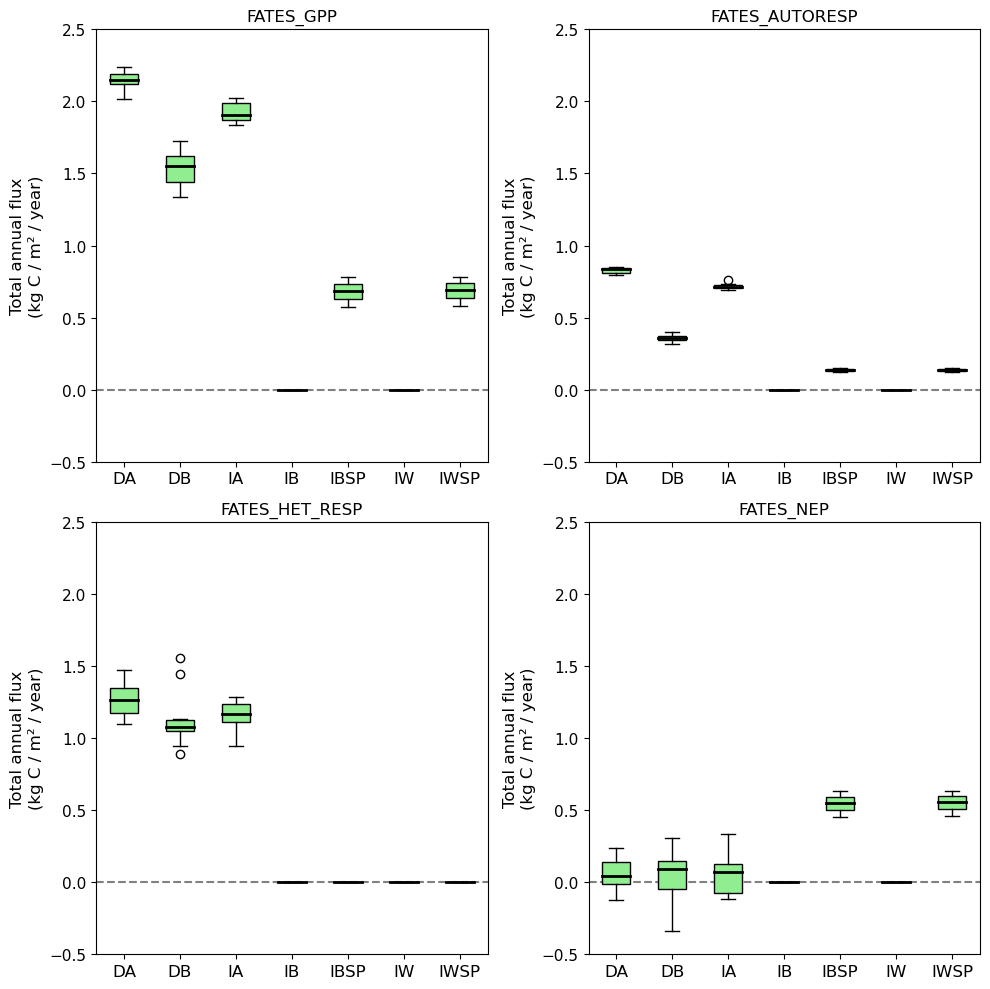

In [8]:
# Instantiate figure with individual figures next to each other
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 10)
)

variables = [
    "FATES_GPP",
    "FATES_AUTORESP",
    "FATES_HET_RESP",
    "FATES_NEP"
]

for index, variable in enumerate(variables):
    # Instantiate plot
    ax = axes[index // 2, index % 2]  # Get the appropriate axis object for the current subplot

    data = [df[variable] for df in dfs.values()]  # Get the data for the current variable from all datasets

    box_plot = ax.boxplot(
        data,
        patch_artist=True,
        medianprops={
            'linewidth': 2,
            'color': 'black'
        }
    )

    box_color = 'lightgreen'
    for patch in box_plot['boxes']:
        patch.set_facecolor(box_color)

    x_labels = [sim for sim in dfs.keys()]  # Use simulation names as x-axis labels

    ax.set_title(variable)
    ax.set_xticklabels(x_labels, fontsize=AX_LABEL_FONT_SIZE)
    ax.set_ylabel("Total annual flux\n(kg C / m² / year)", fontsize=AX_LABEL_FONT_SIZE)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
    ax.tick_params(axis='x', which='major', labelsize=AX_LABEL_FONT_SIZE)

    # Manually set y-ticks
    ax.set_yticks(np.linspace(-0.5, 2.5, num=7))
    # Might need color/transparency adjustment
    ax.axhline(y=0, color='grey', linestyle='dashed', zorder=-1)

fig.tight_layout()
plt.show()


## line plots over time

### All PFTs

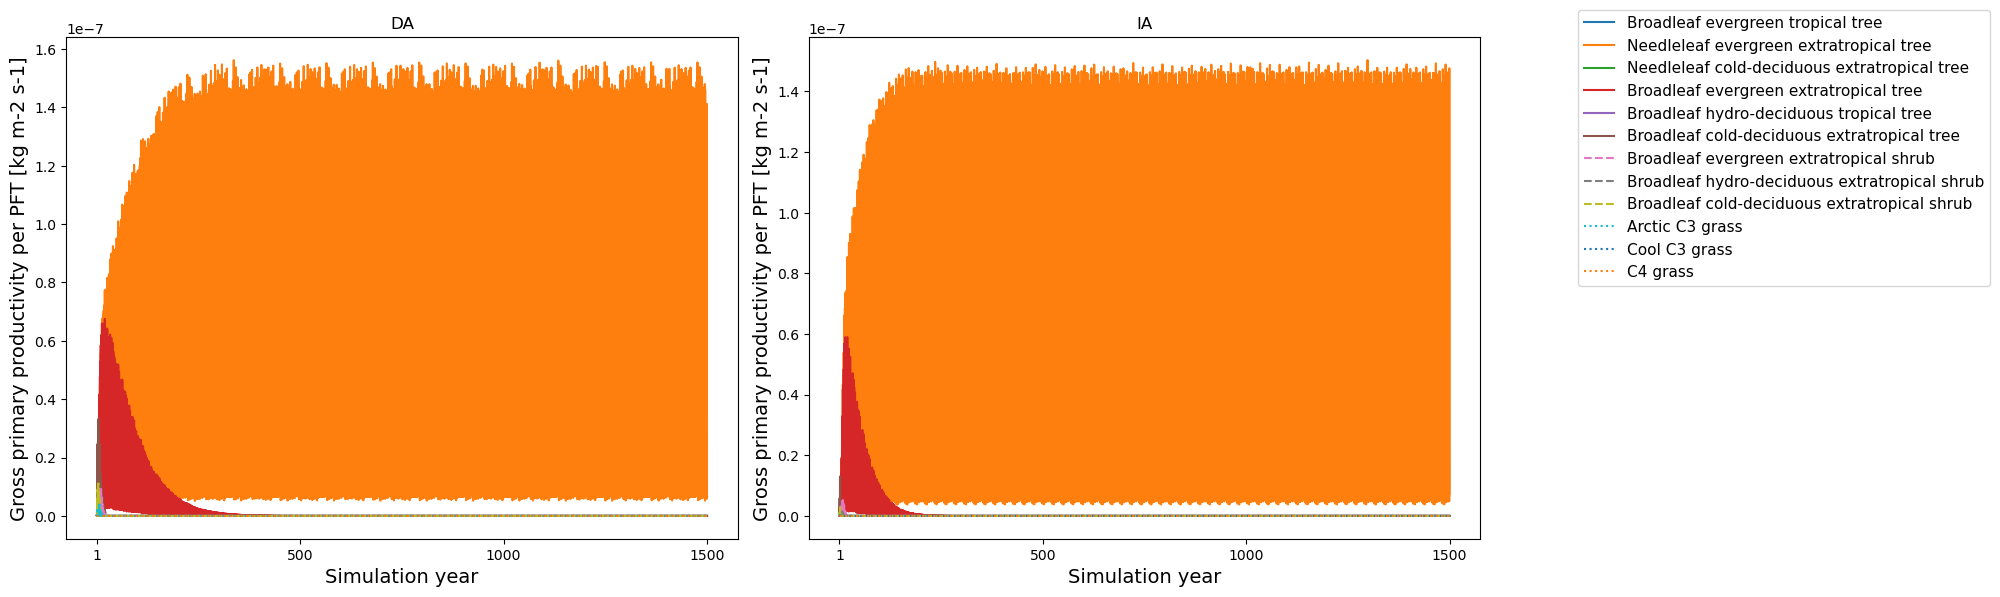

In [28]:
import matplotlib.pyplot as plt

# list simulations to include - can I include the SP mode simulations here?
simulations = ['DA', 'IA']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_GPP_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use default PFT dictionary
    pft_dict = fates_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Gross primary productivity per PFT [{pft_biomass.units}]", fontsize=14)

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


### Grass only

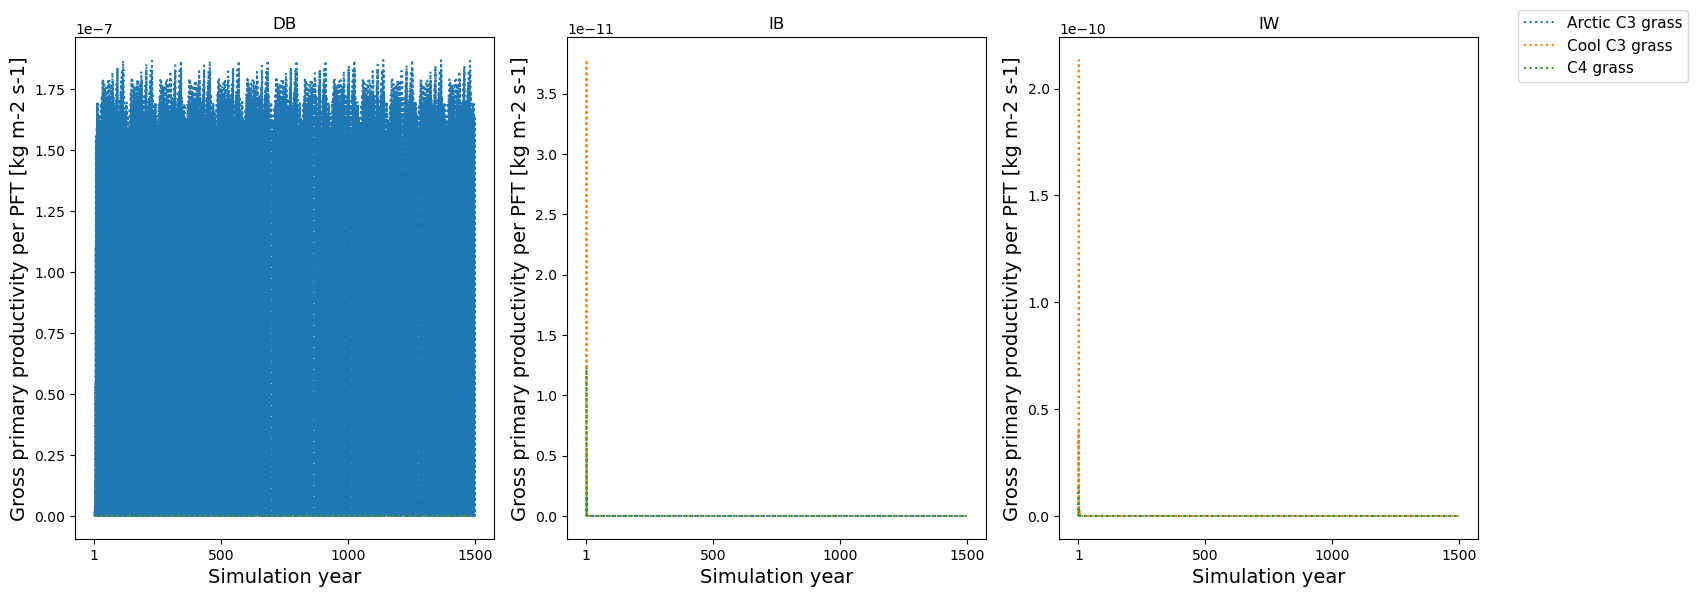

In [31]:
import matplotlib.pyplot as plt

# list simulations to include
simulations = ['DB', 
               'IB',
               'IW']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 6)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_GPP_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use customized PFT dictionary
    pft_dict = custom_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Gross primary productivity per PFT [{pft_biomass.units}]", fontsize=14)

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.01, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


### SP mode

repeat for SP mode simulations. 

In [ ]:
# check which PFTs are present


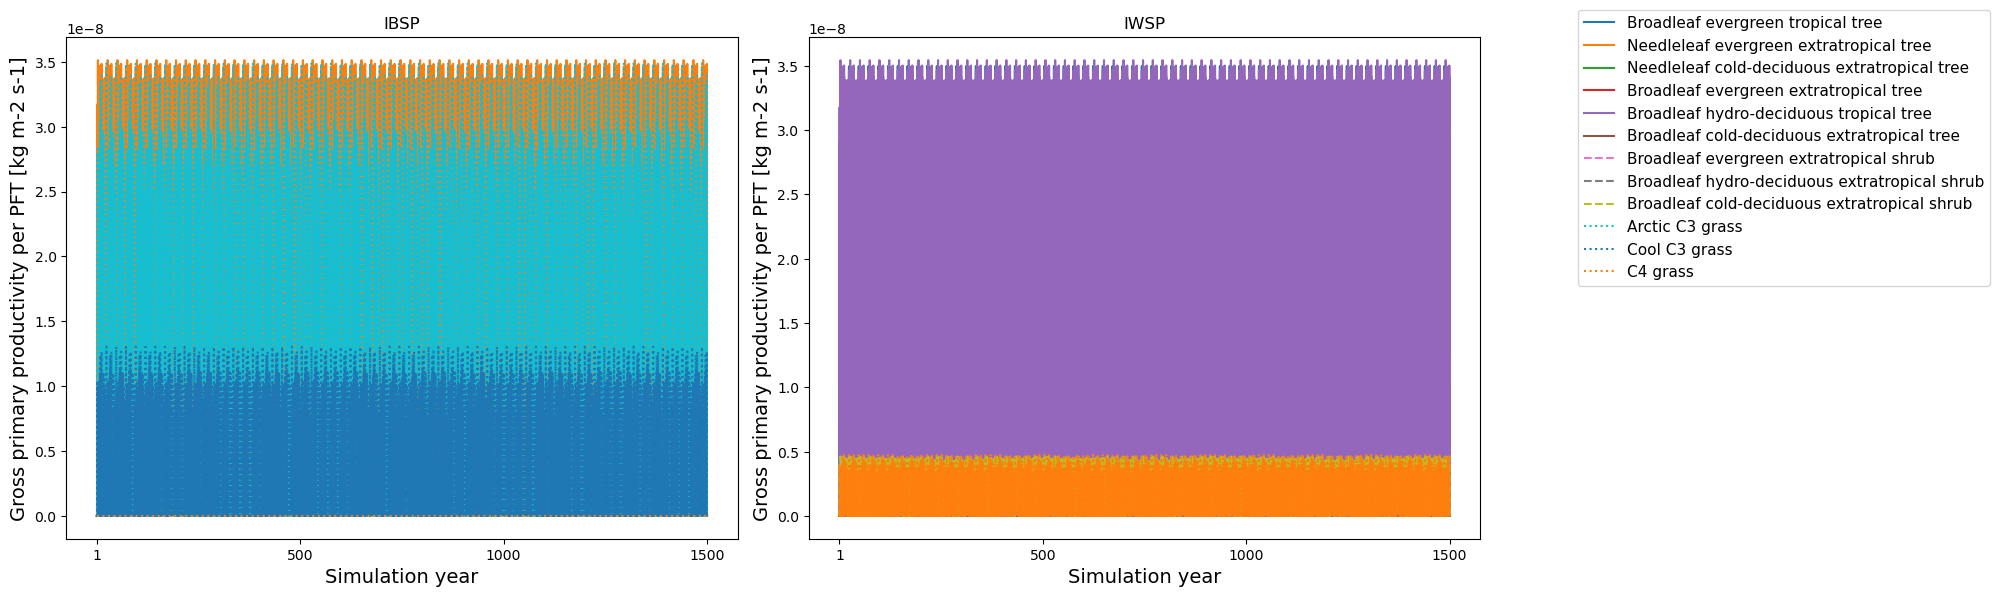

In [32]:
import matplotlib.pyplot as plt

# list simulations to include
simulations = ['IBSP', 'IWSP']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6)
)

# Plot in loop
for i, simulation in enumerate(simulations):
    ax = axes[i]  # Get the appropriate axis object for the current subplot
    
    # subset variable from data
    pft_biomass = data[simulation]["FATES_GPP_PF"]
    
    # Create a multi-line plot by looping through PFT properties
    plot_handle_list = []
    
    # Use default PFT dictionary
    pft_dict = fates_pft_dict
    
    for cur_pft_idx in pft_biomass.fates_levpft:
        
        cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
        
        # Plot biomass for current PFT index
        cur_plot_handles, = ax.plot(range(len(pft_biomass["time"])),
                                    pft_biomass.sel(fates_levpft=cur_pft_idx),
                                    label=cur_pft_dict["long_name"],
                                    linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                    linewidth=1.5
                                   )
        
        plot_handle_list.append(cur_plot_handles)
    
    # Set overall plot layout
    ax.set_title(f"{simulation}")
    ax.set_xlabel("Simulation year", fontsize=14)
    ax.set_ylabel(f"Gross primary productivity per PFT [{pft_biomass.units}]", fontsize=14)

    # Set x-axis tick labels every 500 years
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(labels)

# Create a single legend for all subplots
fig.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot


---
## check spinup phase

In [ ]:
import math

# Variables to plot from 'output_nc_data', feel free to add more names to the list
var_names = ["FATES_VEGC_ABOVEGROUND", "TWS", "TOTSOMC", "TLAI"]

# Instantiate figure with subplot grid adapted to number of variables provided
fig, axes = plt.subplots(
    nrows=math.ceil(len(var_names)/2),
    ncols=2,
    figsize=(15, math.ceil(len(var_names)/2)*6)
)

# Delete empty axis object if number of variable names in list is odd
if len(axes.flatten()) != len(var_names):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# Plot all variables
for ax, var in zip(axes.flatten(), var_names):
    output_nc_data[var].plot(ax=ax)

If you used `runtype=startup` for your simulation, you should see that the values in the plots above start at a somewhat arbitrary value, fluctuate with the seasons, and commonly start increasing over several years. For sufficiently long periods they should stabilize over time: the vegetation and carbon pools reach an equilibrium state. The variables still fluctuate at equilibrium, driven by model processes such as disturbances and plant mortality, and by climatic variability in the forcing data, but the magnitudes and "overall patterns" do not change drastically anymore. Some state variables such as the soil carbon pool can take particularly long until they reach equilibrium due to the slow nature of the involved processes (decomposition, litter buildup, etc.). Reaching a steady state may take a long time, from hundreds to thousands of simulation years, especially in cold or dry climates where vegetation growth is slow.